In [1]:
import pickle
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from torch import nn
from transformers import AutoTokenizer, AutoModel
import torch
from argparse import ArgumentParser
import pytorch_lightning as pl
from matplotlib import pyplot
from torch.nn import functional as F
import random
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import logging
logging.set_verbosity_error()

from utils import Plot_results, Create_data
from Linking_AE_training.VAE_Final_Architecture import VAE
from Linking_AE_training.Linking_AE_Architectures import Linking_AE

c:\Users\ID\.conda\envs\pl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ID\.conda\envs\pl\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\Users\ID\.conda\envs\pl\lib\site-packages\pl_bolts\__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
c:\Users\ID\.conda\envs\pl\lib\site-packages\pl_bolts\__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
c:\Users\ID\.conda\envs\pl\lib\site-packages\pl_bolts\models\self_supervised\amdim\amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. T

This file presents the pipeline for predicting the nanomaterial image from the synthesis text. For this purpose, the checkpoints of the trained VAE and linking AE are used. The text is passed to the input below and resulted image is saved as result.png

In [2]:
input = "All the materials were synthesized by the co-precipitation technique. First, 81 mkl of 1 M CaCl2 was mixed with 20 mkl of 0.335 % wt. PVP polymer with molecular weight of 40.0 kDa. Then, 0.0 mkl of None was added, following adjustment with distilled water up to 500 mkl. Then, 22 mkl of 0.1 M Na2CO3 was mixed with 0 mkl of 0.1 M of NaHCO3 and 20 mkl of 0.425 % wt. Myristyltrimethylammonium bromide as surfactant. Then, 0.0 mkl of None was added, following adjustment with distilled water up to 500 mkl. Two resulting solutions, heated up to 58 C before the reaction, were mixed under the stirring with 0 rpm, while the temperature kept unchanged. Reaction proceeded for 89 min 0 sec min following centrifugation."

In [3]:
path_to_data = "Datasets/Augmented_One_Particle_Dataset"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
preprocessed_data = Create_data(path_to_data, pattern=0)

In [5]:
link_ckpt_path = "Linking_AE_training/Result_Linking_AE/Linking_AE_Test/version_0/checkpoints/epoch=199-step=44000.ckpt"
vae_ckpt_path = "VAE_Training/Results_VAE/Results_VAE_Final_Validation/version_0/checkpoints/epoch=39-step=26320.ckpt" 

In [6]:
def Load_text_model(device):
    #Загрузка токенизатора и самой модели
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    model = AutoModel.from_pretrained("bert-base-uncased").to(device)
    return model, tokenizer

In [7]:
def Create_text_embeddings(preprocessed_data, device, batch_size = 200):
    model, tokenizer = Load_text_model(device)
    bert_input = preprocessed_data
    embeddings = torch.tensor([])
    for index, batch in enumerate(bert_input):
        tokenized_train = tokenizer(batch, padding = 'max_length', truncation = True, return_tensors="pt", max_length=256)
        #move on device (GPU)
        tokenized_train = {k:v.clone().detach().to(device) for k,v in tokenized_train.items()}
        with torch.no_grad():
            hidden_train = model(**tokenized_train) #dim : [batch_size(nr_sentences), tokens, emb_dim]
            embeddings = torch.cat((embeddings, hidden_train.last_hidden_state[:, :, :,].detach().cpu()[:,0]), 0)
        print('Batch', str(index + 1), 'completed out of', len(bert_input))
    return embeddings

In [8]:
Text_embeddings = Create_text_embeddings([input], device, batch_size=1000)

Batch 1 completed out of 1


In [10]:
ae = Linking_AE.load_from_checkpoint(link_ckpt_path)

In [11]:
with torch.no_grad():
    ae.eval()
    embedding = ae(Text_embeddings.to(ae.device))
    ae.train()

In [12]:
model = VAE.load_from_checkpoint(vae_ckpt_path)

In [13]:
mu = model.fc_mu(embedding.to(ae.device))
log_var = model.fc_var(embedding.to(ae.device))
p, q, z = model.sample(mu, log_var)
decoded = model.decoder(z)

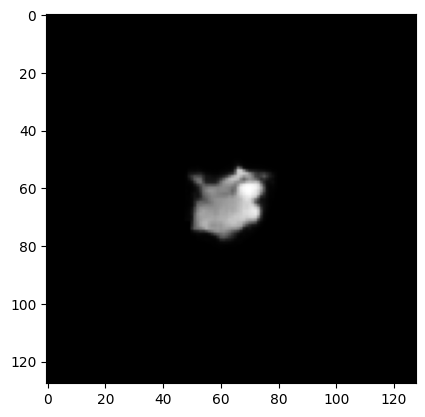

In [16]:
pyplot.figure()
pyplot.imshow(decoded.cpu().detach().numpy()[0][0], cmap="gray")
pyplot.savefig("result.png")